In [1]:
import numpy as np
import pandas as pd

pd.set_option('max_columns', 200)
pd.options.display.max_rows = 250

import pandas_profiling as pp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import math, string, os

In [2]:
train_df = pd.read_csv('train.csv', low_memory = False)

In [3]:
#train_df.head(22)

In [4]:
#train_df['Yards'].describe()

In [5]:
#train_df.isnull().sum()

In [6]:
def Offense(row):
    if row["Team"] == "home":
        if row["HomeTeamAbbr"] == row["PossessionTeam"]:
            return 1
        else:
            return 0
    elif row["Team"] == "away":
        if row["VisitorTeamAbbr"] == row["PossessionTeam"]:
            return 1
        else:
            return 0

train_df["Offense"] = train_df.apply(lambda row: Offense(row), axis=1)

In [7]:
def Home(row):
    if row["Team"] == "home":
        return 1
    else:
        return 0

train_df["Home"] = train_df.apply(lambda row: Home(row), axis=1)

In [8]:
def Rusher(row):
    if row["NflId"] == row['NflIdRusher']:
        return 1
    else:
        return 0
    
train_df["Rusher"] = train_df.apply(lambda row: Rusher(row), axis = 1)

In [9]:
def DefenseTeam(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return row["VisitorTeamAbbr"]
    else:
        return row["HomeTeamAbbr"]
    
train_df["DefenseTeam"] = train_df.apply(lambda row: DefenseTeam(row), axis = 1)

In [10]:
#pd.DataFrame(train_df['GameWeather'].value_counts())

In [11]:
def group_game_weather(weather):
    rain = [
        'Rainy', 'Showers', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Rain'
    ]
    overcast = [
        'Rain Chance 40%', 'Party Cloudy', 'Cloudy, chance of rain', 'Rain likely, temps in low 40s.','Light Rain', 
        'Coudy', 'Cloudy, 50% change of rain', 
        'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
        'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
        'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
        'Partly Cloudy', 'Cloudy'
    ]
    clear = [
        'Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
        'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
        'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
        'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
        'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny'
    ]
    snow  = ['Heavy lake effect snow', 'Snow', 'Cloudy, light snow accumulating 1-3"']
    none  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 0
    elif weather in overcast:
        return 0
    elif weather in clear:
        return 0
    elif weather in snow:
        return 1
    elif weather in none:
        return 0
    return 0
    
train_df['GameWeather'] = train_df['GameWeather'].apply(group_game_weather)

In [12]:
#pd.DataFrame(train_df['StadiumType'].value_counts())

In [13]:
def group_stadium_types(stadium):
    outdoor       = [
        'Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
        'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
        'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl'
    ]
    indoor_closed = [
        'Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
        'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
    ]
    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 1
    elif stadium in indoor_closed:
       return 0
    elif stadium in indoor_open:
       return 0
    elif stadium in dome_closed:
       return 0
    elif stadium in dome_open:
       return 0
    else:
       return 1
    
train_df['StadiumType'] = train_df['StadiumType'].apply(group_stadium_types)

In [14]:
#pd.options.display.max_rows = 250
#pd.DataFrame(train_df['WindSpeed'].value_counts())

In [15]:
#More Robust Solution?

def clean_wind_speed(windspeed):
    """
    This is not a very robust function, 
    but it should do the job for this dataset.
    """
    ws = str(windspeed)
    # if it's already a number just return an int value
    if ws.isdigit():
        return int(ws)
    # if it's a range, just take the first value
    if '-' in ws:
        return int(ws.split('-')[0])
    # if there's a space between the number and mph
    if ws.split(' ')[0].isdigit():
        return int(ws.split(' ')[0])
    # if it looks like '10MPH' or '12mph' just take the first part
    if 'mph' in ws.lower():
        return int(ws.lower().split('mph')[0])
    else:
        return 0
    
train_df['WindSpeed'] = train_df['WindSpeed'].apply(clean_wind_speed)

In [16]:
#pd.DataFrame(train_df['WindDirection'].value_counts())

In [17]:
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM S' in wd:
        return 'north'
    if wd == 'S' or 'FROM N' in wd:
        return 'south'
    if wd == 'W' or 'FROM E' in wd:
        return 'west'
    if wd == 'E' or 'FROM W' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'north east'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'north west'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'south east'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'south west'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'none'
train_df['WindDirection'] = train_df['WindDirection'].apply(clean_wind_direction)

In [18]:
#pd.DataFrame(train_df['FieldPosition'].value_counts())

In [19]:
train_df['FieldPosition'] = np.where(train_df['YardLine'] == 50, train_df['PossessionTeam'], train_df['FieldPosition'])

train_df['Humidity'].fillna(train_df['Humidity'].mean(), inplace=True)
train_df['Temperature'].fillna(train_df['Temperature'].mean(), inplace=True)

na_map = {
    'Orientation': train_df['Orientation'].mean(),
    'Dir': train_df['Dir'].mean(),
    'DefendersInTheBox': train_df['DefendersInTheBox'].mean(),
    'OffenseFormation': 'UNKNOWN'
}

def height_to_numerical(height):
    feet   = height.split('-')[0]
    inches = height.split('-')[1]
    return int(feet)*12 + int(inches)
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(height_to_numerical)

train_df.fillna(na_map, inplace=True)

In [20]:
#pd.DataFrame(train_df['FieldPosition'].value_counts())

In [21]:
#train_df.isnull().sum()

In [22]:
train_df.loc[train_df['PossessionTeam'] == 'ARZ', 'PossessionTeam'] = 'ARI'
train_df.loc[train_df['PossessionTeam'] == 'BLT', 'PossessionTeam'] = 'BAL'
train_df.loc[train_df['PossessionTeam'] == 'CLV', 'PossessionTeam'] = 'CLE'
train_df.loc[train_df['PossessionTeam'] == 'HST', 'PossessionTeam'] = 'HOU'

In [23]:
#train_df['HomeTeamAbbr'].value_counts()

In [24]:
#len(train_df['HomeTeamAbbr'].value_counts())

In [25]:
#train_df['VisitorTeamAbbr'].value_counts()

In [26]:
#len(train_df['VisitorTeamAbbr'].value_counts())

In [27]:
#This loads slowly but is very thorough
#pp.ProfileReport(train_df)

In [28]:
#train_df['OffensePersonnel'].value_counts()

In [29]:
#train_df['DefensePersonnel'].value_counts()

In [30]:
train_df.head(22)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Offense,Home,Rusher,DefenseTeam
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,74,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,71,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,74,208,03/05/1990,Brigham Young,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,0,0,0,KC
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 

In [31]:
rushing_df = train_df[ train_df['NflId'] == train_df['NflIdRusher']]
print(rushing_df.shape)
rushing_df.head()

(23171, 53)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Offense,Home,Rusher,DefenseTeam
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,2543773,James White,28,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,70,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,1,1,1,KC
40,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,2543773,James White,28,2017,43,1,13:52:00,NE,1,10,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:27.000Z,2017-09-08T00:44:26.000Z,3,70,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,1,1,1,KC
62,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,2543773,James White,28,2017,35,1,13:02:00,NE,1,10,KC,0,0,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:45:17.000Z,2017-09-08T00:45:15.000Z,5,70,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,1,1,1,KC
84,2017090700,20170907000345,home,15.53,25.36,4.45,3.20,0.46,186.22,275.44,2539663,Mike Gillislee,35,2017,2,1,12:12:00,NE,2,2,KC,0,0,2539663,JUMBO,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",left,2017-09-08T00:48:41.000Z,2017-09-08T00:48:39.000Z,2,71,210,11/01/1990,Florida,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,1,1,1,KC
98,2017090700,20170907000395,away,29.99,27.12,3.90,2.53,0.44,34.27,157.92,2557917,Kareem Hunt,27,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,71,216,08/06/1995,Toledo,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1,Field Turf,0,63.0,77.0,8,south west,1,0,1,NE


In [32]:
y = rushing_df['Yards']
x1 = rushing_df[['YardLine','Down','Distance','S','A','DefendersInTheBox','StadiumType',]]
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

#StadiumType might be explained by other variables if type outdoor and visitor stadiumtype = indoor
#if for example outdoor team weight > indoor team weight and weight advantage is beneficial for rushing

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yards   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     162.5
Date:                Sun, 13 Oct 2019   Prob (F-statistic):          1.56e-235
Time:                        03:17:43   Log-Likelihood:                -75466.
No. Observations:               23171   AIC:                         1.509e+05
Df Residuals:                   23163   BIC:                         1.510e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2941      0.471      2.748      0.006       0.371       2.217
YardLine              0.0213      0.003      6.591      0.000       0.015       0.028
Down                  0.0783      0.071      1.098      0.272      -0.061       0.218
Distance              0.0849      0.013      6.480      0.000       0.059       0.111
S                     0.5131      0.036     14.151      0.000       0.442       0.584
A                     1.0330      0.044     23.538      0.000       0.947       1.119
DefendersInTheBox    -0.5105      0.044    -11.521      0.000      -0.597      -0.424
StadiumType           0.2132      0.094      2.267      0.023       0.029       0.397
==============================================================================
Omnibus:                    21258.843   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1253421.943
Skew:                           4.283   Prob(JB):                         0.00
Kurtosis:                      37.999   Cond. No.                         381.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
train_df['Position'].value_counts(normalize = True)

CB     0.111201
WR     0.104608
G      0.082615
T      0.082482
DE     0.070405
DT     0.069909
OLB    0.066914
TE     0.065201
FS     0.048272
C      0.047202
RB     0.046900
QB     0.045688
SS     0.040293
ILB    0.036372
MLB    0.020025
NT     0.016137
LB     0.013141
OT     0.011960
FB     0.006299
OG     0.006028
DB     0.003788
S      0.003219
HB     0.001269
SAF    0.000037
DL     0.000033
Name: Position, dtype: float64

In [34]:
rushing_df['Position'].value_counts(normalize = True)

RB    0.933408
WR    0.027534
HB    0.026585
FB    0.007294
QB    0.003323
TE    0.001338
CB    0.000388
DT    0.000086
DE    0.000043
Name: Position, dtype: float64

In [35]:
rushing_df[rushing_df['Position'] == 'CB']

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Offense,Home,Rusher,DefenseTeam
129491,2017110506,20171105060104,home,61.48,24.15,3.40,3.57,0.39,324.09,38.05,2558065,Adoree' Jackson,25,2017,44,1,13:56:00,TEN,2,8,BLT,0,0,2558065,SHOTGUN,"1 RB, 0 TE, 3 WR,1 DB",7.0,"2 DL, 4 LB, 5 DB",right,2017-11-05T18:04:38.000Z,2017-11-05T18:04:36.000Z,20,71,185,09/18/1995,Southern California,CB,TEN,BAL,9,Nissan Stadium,"Nashville, TN",1,Grass,0,75.000000,66.000000,10,south west,1,1,1,BAL
134342,2017110600,20171106000518,away,57.40,25.85,6.92,3.25,0.71,281.12,352.87,2558821,Jamal Agnew,39,2017,45,1,03:47:00,DET,1,10,GB,0,0,2558821,SINGLEBACK,"1 RB, 1 TE, 2 WR,1 DB",7.0,"2 DL, 3 LB, 6 DB",right,2017-11-07T01:47:09.000Z,2017-11-07T01:47:08.000Z,4,70,190,04/03/1995,San Diego,CB,GB,DET,9,Lambeau Field,"Green Bay, WI",1,DD GrassMaster,0,35.000000,58.000000,3,south west,1,0,1,GB
142779,2017111206,20171112061099,home,31.41,30.82,5.62,4.19,0.56,319.46,8.17,2558065,Adoree' Jackson,25,2017,26,2,11:34:00,TEN,2,4,TEN,7,6,2558065,SHOTGUN,"1 RB, 0 TE, 3 WR,1 DB",6.0,"4 DL, 2 LB, 5 DB",right,2017-11-12T18:49:11.000Z,2017-11-12T18:49:09.000Z,20,71,185,09/18/1995,Southern California,CB,TEN,CIN,10,Nissan Stadium,"Nashville, TN",1,Grass,0,53.000000,88.000000,4,south west,1,1,1,CIN
143087,2017111206,20171112062535,home,30.81,48.21,4.65,2.58,0.47,23.51,56.09,2558065,Adoree' Jackson,25,2017,25,3,09:03:00,TEN,2,8,TEN,17,13,2558065,SHOTGUN,"1 RB, 1 TE, 2 WR,1 DB",7.0,"4 DL, 3 LB, 4 DB",right,2017-11-12T20:02:19.000Z,2017-11-12T20:02:16.000Z,13,71,185,09/18/1995,Southern California,CB,TEN,CIN,10,Nissan Stadium,"Nashville, TN",1,Grass,0,53.000000,88.000000,4,south west,1,1,1,CIN
143329,2017111206,20171112063586,home,88.47,21.48,5.33,0.77,0.58,121.64,193.75,2558065,Adoree' Jackson,25,2017,26,4,06:45:00,TEN,2,10,TEN,17,13,2558065,SHOTGUN,"1 RB, 0 TE, 3 WR,1 DB",7.0,"4 DL, 3 LB, 4 DB",left,2017-11-12T20:47:17.000Z,2017-11-12T20:47:15.000Z,-3,71,185,09/18/1995,Southern California,CB,TEN,CIN,10,Nissan Stadium,"Nashville, TN",1,Grass,0,53.000000,88.000000,4,south west,1,1,1,CIN
149741,2017111600,20171116000514,away,41.85,28.03,5.67,3.15,0.58,76.59,168.19,2558065,Adoree' Jackson,25,2017,36,1,08:58:00,TEN,2,6,TEN,10,0,2558065,EMPTY,"1 RB, 3 TE, 0 WR,1 DB",8.0,"3 DL, 4 LB, 4 DB",right,2017-11-17T01:46:50.000Z,2017-11-17T01:46:49.000Z,5,71,185,09/18/1995,Southern California,CB,PIT,TEN,11,Heinz Field,Pittsburgh,1,Grass,0,40.000000,67.000000,11,east,1,0,1,PIT
310362,2018093002,20180930021499,away,43.17,24.46,8.66,3.19,0.88,5.33,7.84,2558821,Jamal Agnew,39,2018,30,2,05:35:00,DET,1,10,DAL,6,7,2558821,SINGLEBACK,"1 RB, 1 TE, 2 WR,1 DB",7.0,"4 DL, 2 LB, 5 DB",left,2018-09-30T18:11:04.000Z,2018-09-30T18:11:03.000Z,17,70,190,04/03/1995,San Diego,CB,DAL,DET,4,AT&T Stadium,"Arlington, Texas",0,Artificial,0,60.436442,55.646062,0,none,1,0,1,DAL
361931,2018102110,20181021102756,away,49.45,29.22,8.15,0.96,0.82,3.62,1.71,2557920,Jourdan Lewis,27,2018,36,4,11:18:00,DAL,1,10,WAS,13,7,2557920,SINGLEBACK,"1 RB, 1 TE, 2 WR,1 DB",7.0,"2 DL, 4 LB, 5 DB",left,2018-10-21T22:40:57.000Z,2018-10-21T22:40:56.000Z,7,70,195,08/31/1995,Michigan,CB,WAS,DAL,7,FedExField,"Landover, MD",1,Grass,0,52.000000,43.000000,12,north west,1,0,1,WAS
405469,2018111800,20181118002325,away,45.87,30.64,7.88,0.18,0.78,1.48,356.51,2557920,Jourdan Lewis,27,2018,40,3,04:33:00,DAL,2,6,DAL,9,6,2557920,SINGLEBACK,"1 RB, 2 TE, 1 WR,1 DB",7.0,"3 DL, 3 LB, 5 DB",right,2018-11-18T19:51:19.000Z,2018-11-18T19:51:18.000Z,5,70,195,08/31/1995,Michigan,CB,ATL,DAL,11,Mercedes-Benz Stad

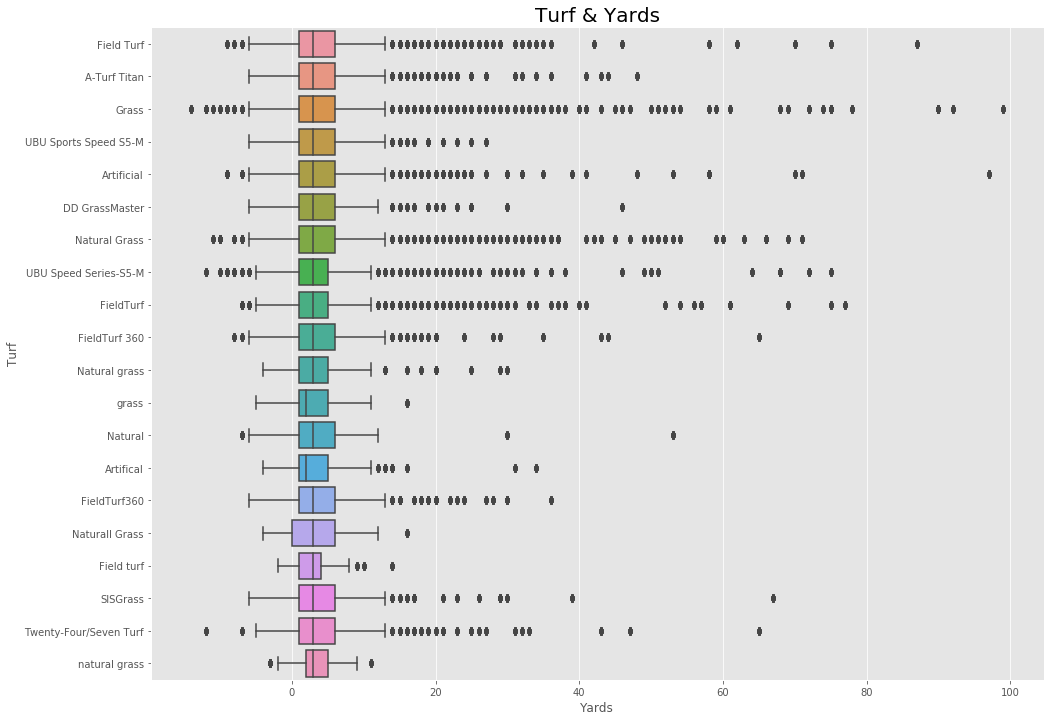

In [36]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="Turf", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Turf', fontsize=12)
plt.title("Turf & Yards", fontsize=20)
plt.show()

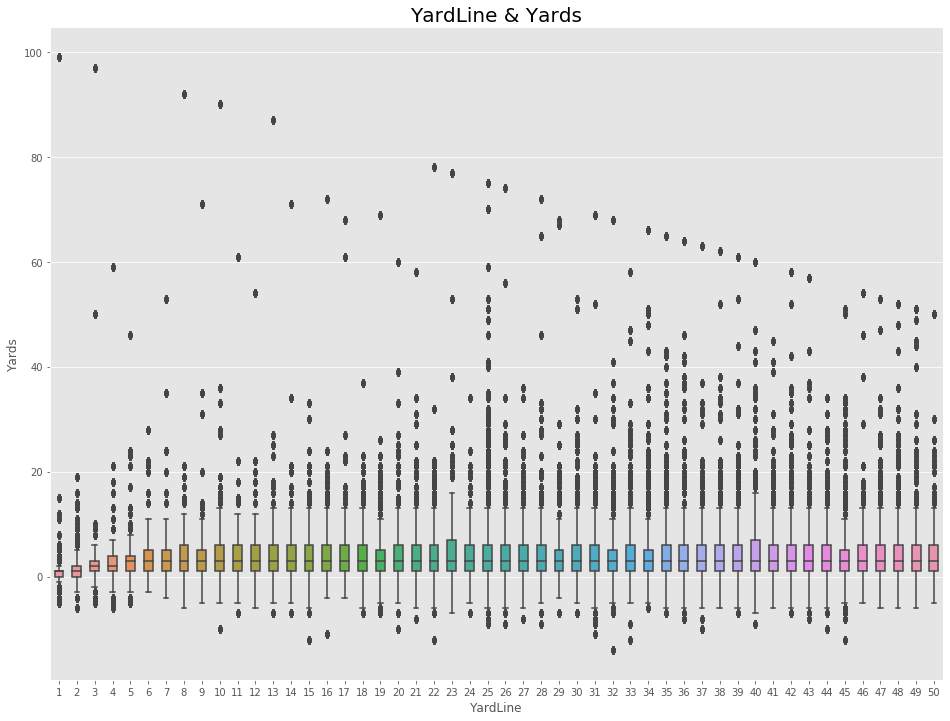

In [37]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="YardLine", y="Yards", showfliers=True, width = .5)
plt.xlabel('YardLine', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("YardLine & Yards", fontsize=20)
plt.show()

#Interesting to note linear caps on range but also seemingly as YardLine Increases so does Yards

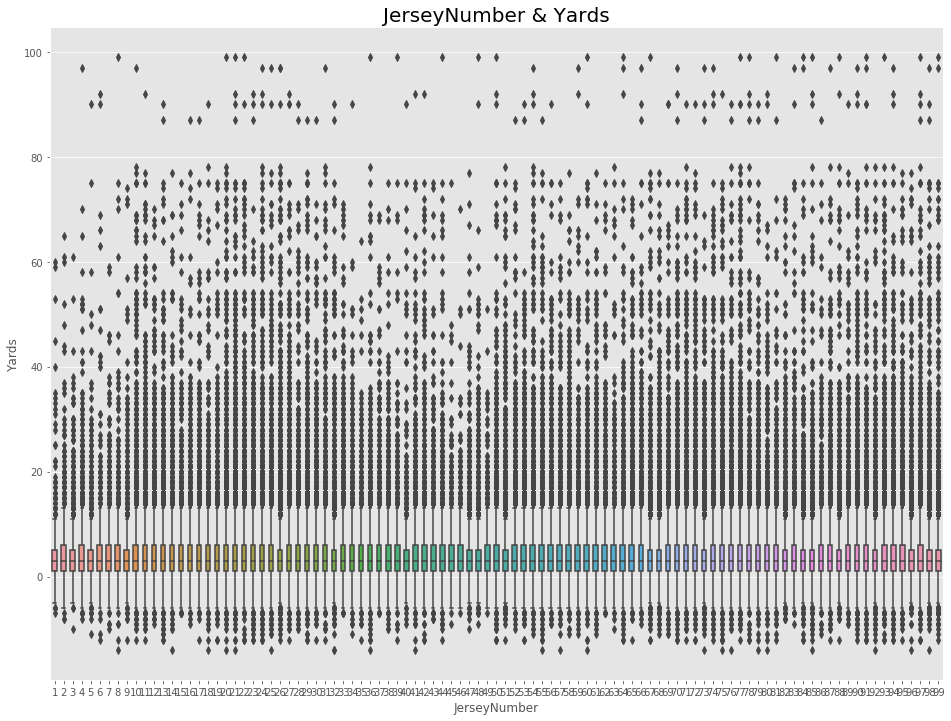

In [38]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="JerseyNumber", y="Yards", showfliers=True, width = .5)
plt.xlabel('JerseyNumber', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("JerseyNumber & Yards", fontsize=20)
plt.show()

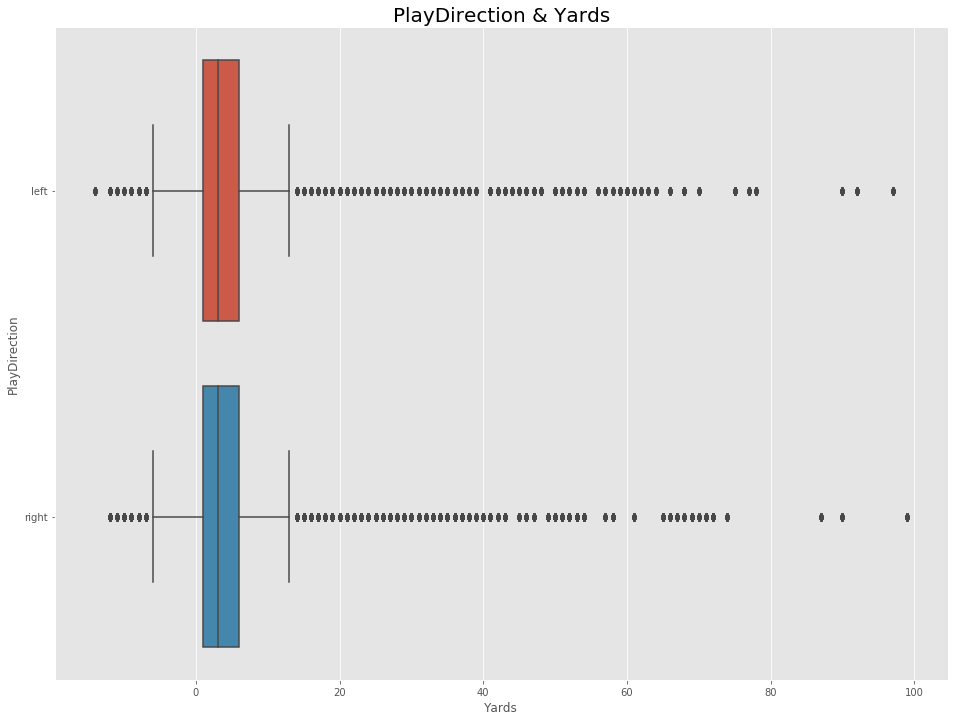

In [39]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="PlayDirection", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PlayDirection', fontsize=12)
plt.title("PlayDirection & Yards", fontsize=20)
plt.show()

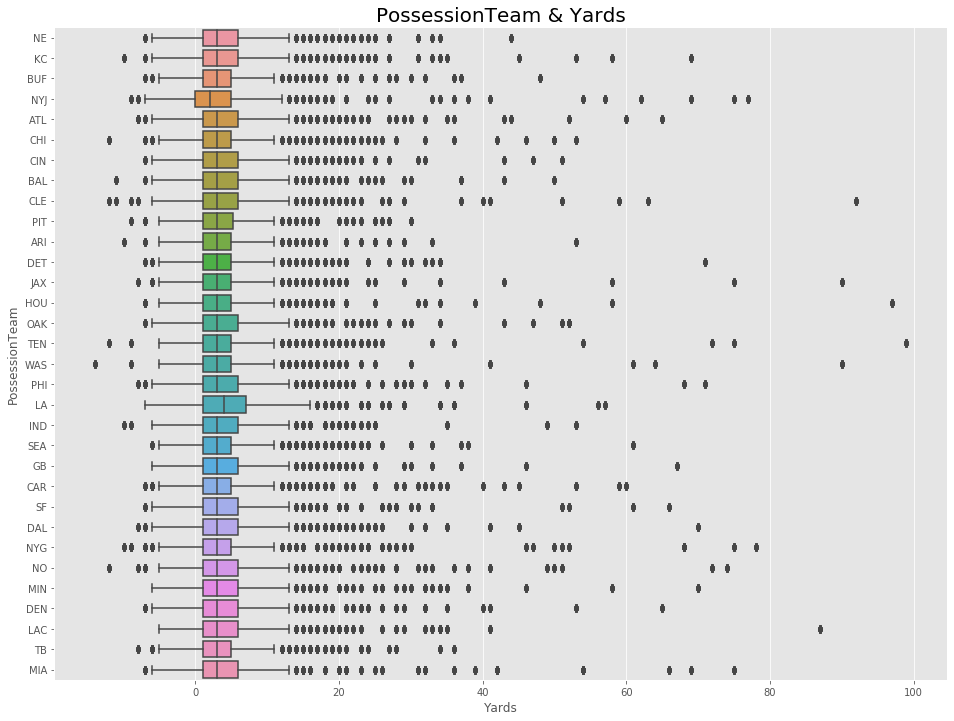

In [40]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="PossessionTeam", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PossessionTeam', fontsize=12)
plt.title("PossessionTeam & Yards", fontsize=20)
plt.show()

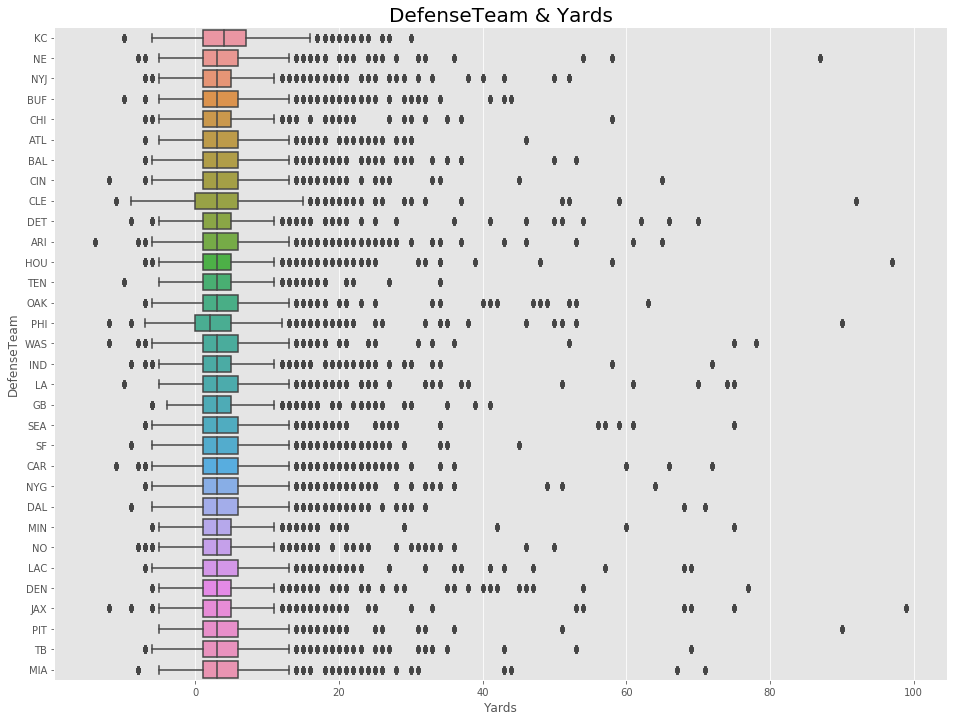

In [59]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="DefenseTeam", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('DefenseTeam', fontsize=12)
plt.title("DefenseTeam & Yards", fontsize=20)
plt.show()

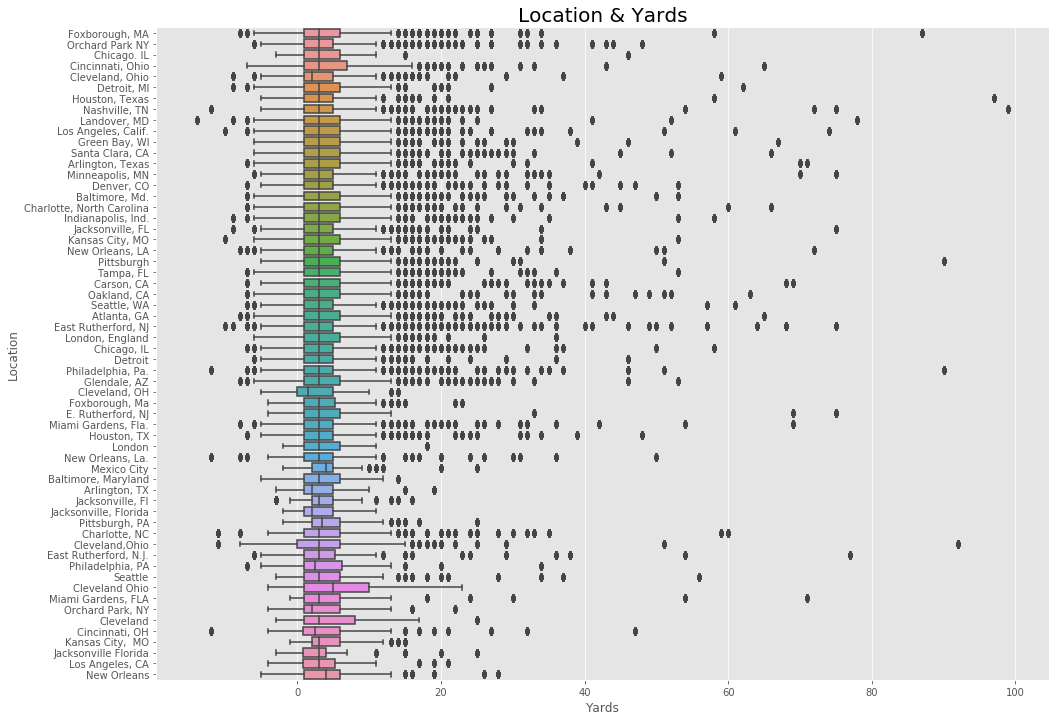

In [41]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="Location", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.title("Location & Yards", fontsize=20)
plt.show()

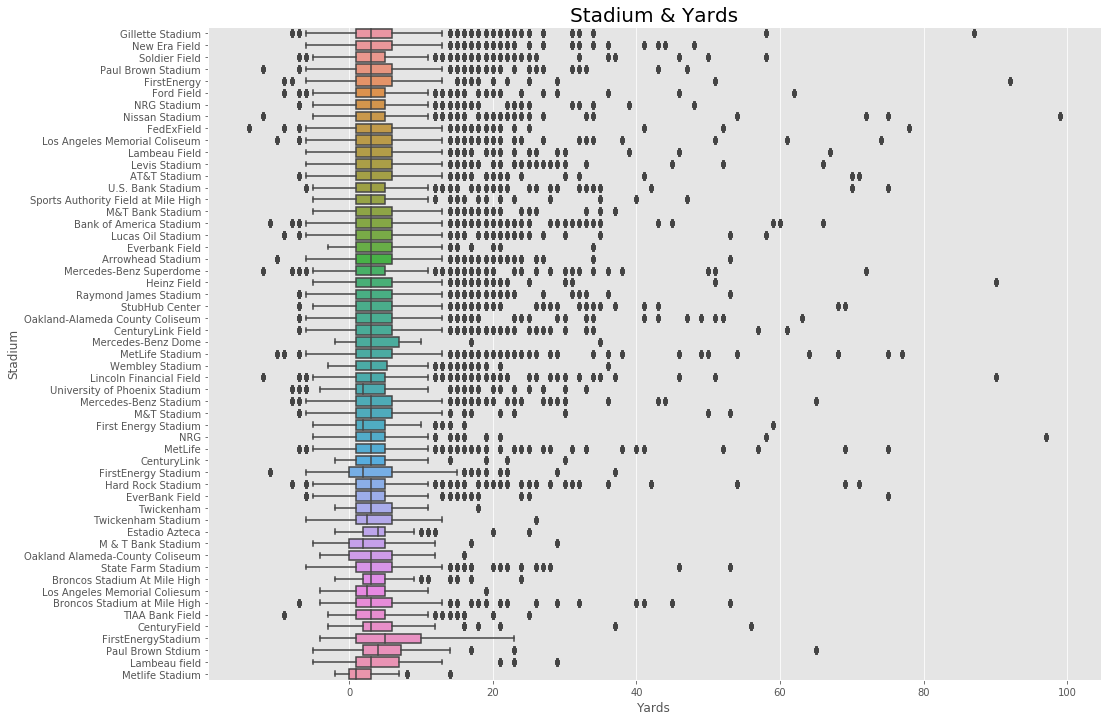

In [42]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="Stadium", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Stadium', fontsize=12)
plt.title("Stadium & Yards", fontsize=20)
plt.show()

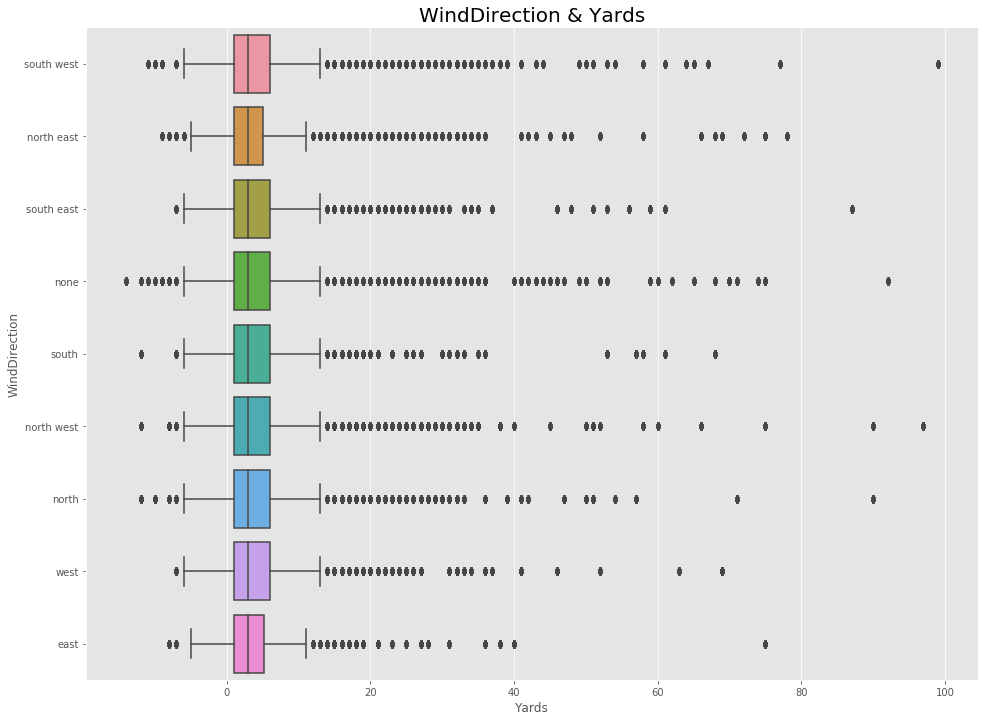

In [43]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="WindDirection", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('WindDirection', fontsize=12)
plt.title("WindDirection & Yards", fontsize=20)
plt.show()

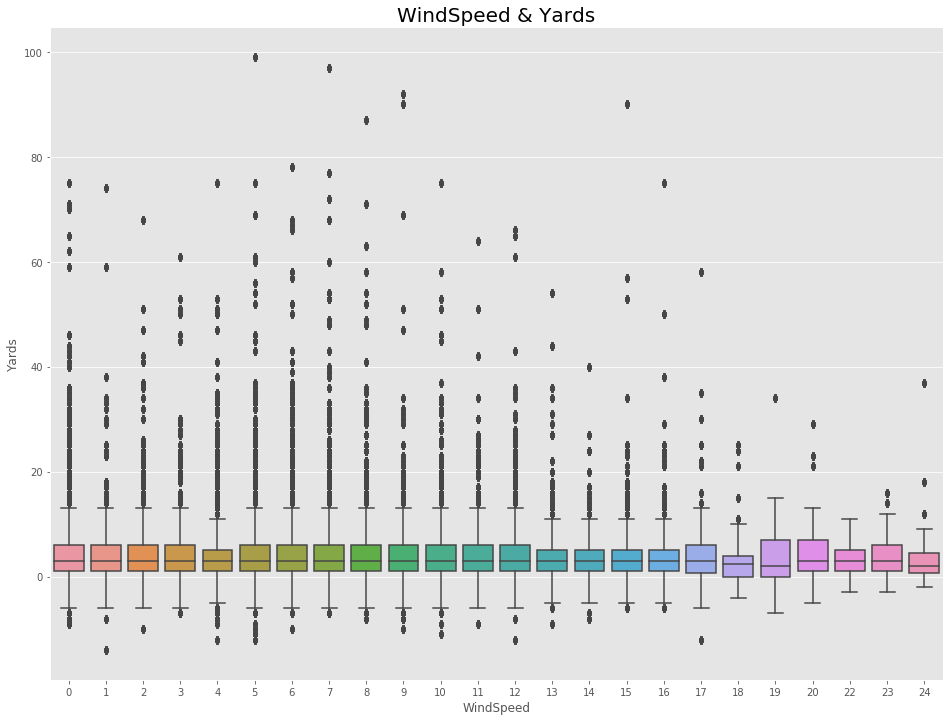

In [44]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="WindSpeed", y="Yards", showfliers=True)
plt.xlabel('WindSpeed', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("WindSpeed & Yards", fontsize=20)
plt.show()

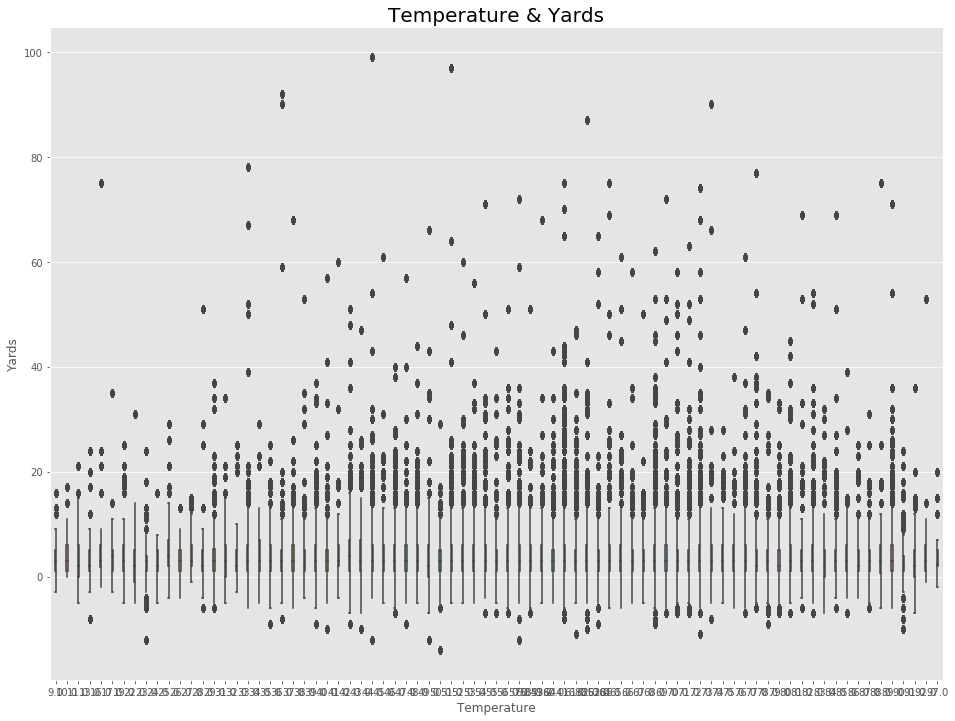

In [45]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Temperature", y="Yards", showfliers=True, width = .1)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Temperature & Yards", fontsize=20)
plt.show()

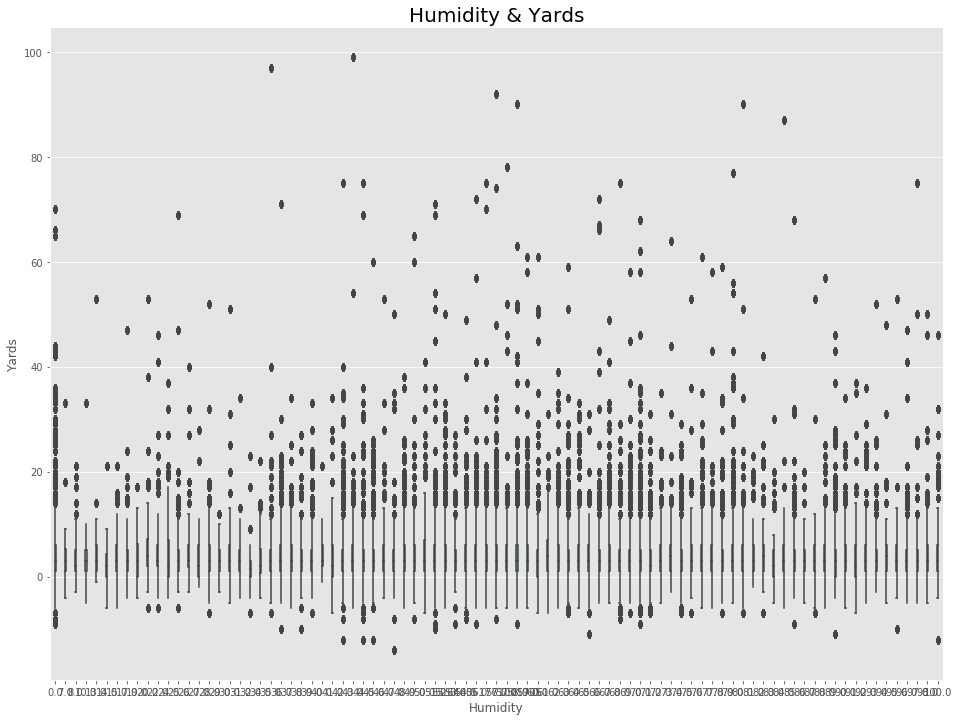

In [46]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Humidity", y="Yards", showfliers=True, width = .1)
plt.xlabel('Humidity', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Humidity & Yards", fontsize=20)
plt.show()

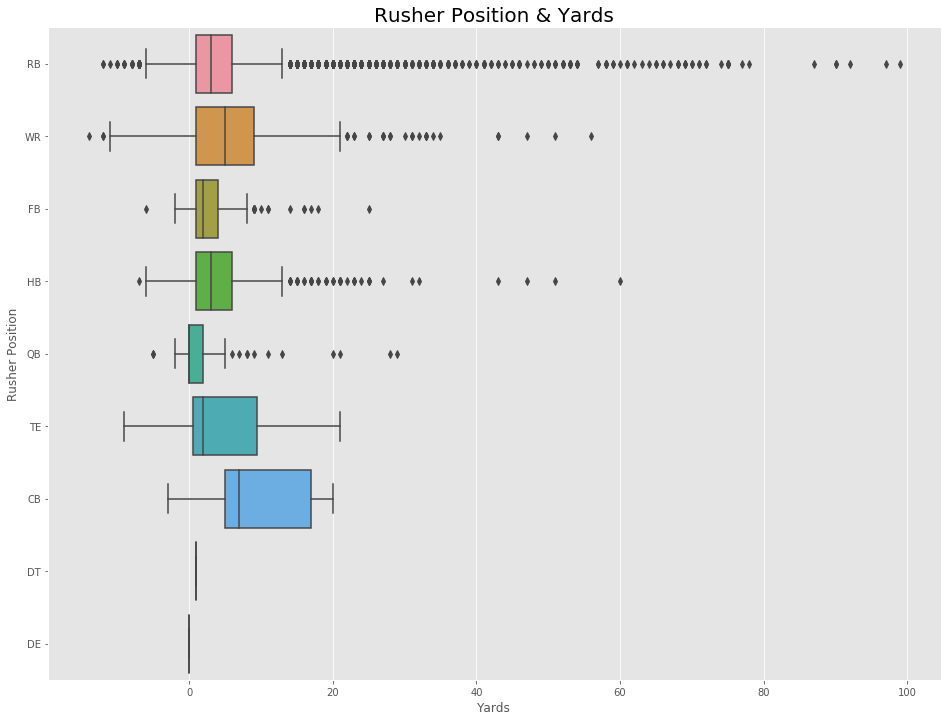

In [47]:
plt.figure(figsize=(16,12))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="Yards", y="Position", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Rusher Position', fontsize=12)
plt.title("Rusher Position & Yards", fontsize=20)
plt.show()

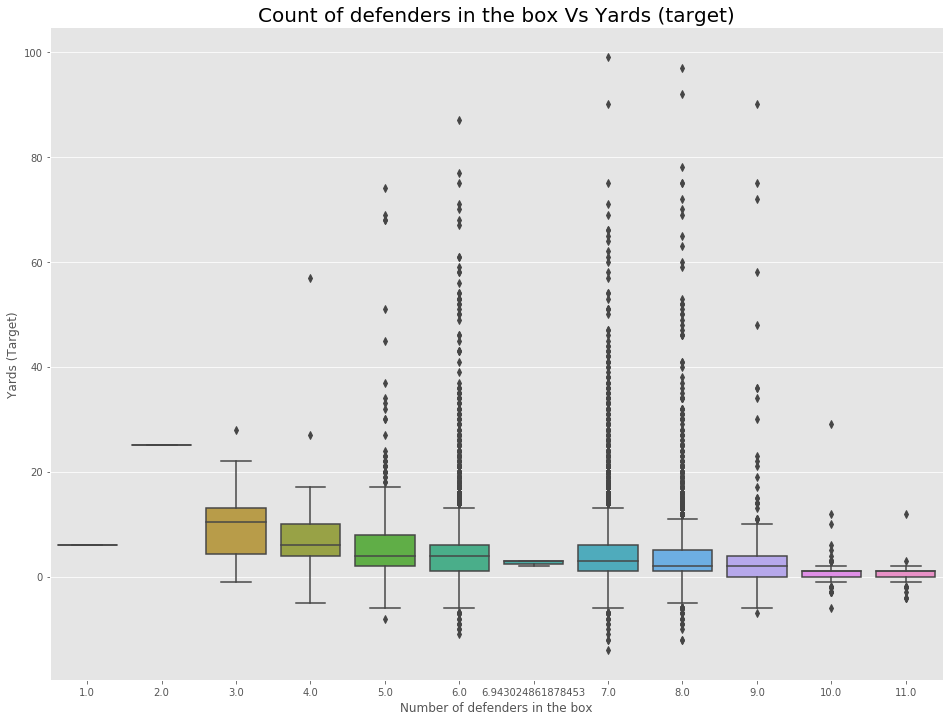

In [48]:
plt.figure(figsize=(16,12))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="DefendersInTheBox", y="Yards", showfliers=True)
plt.xlabel('Number of defenders in the box', fontsize=12)
plt.ylabel('Yards (Target)', fontsize=12)
plt.title("Count of defenders in the box Vs Yards (target)", fontsize=20)
plt.show()

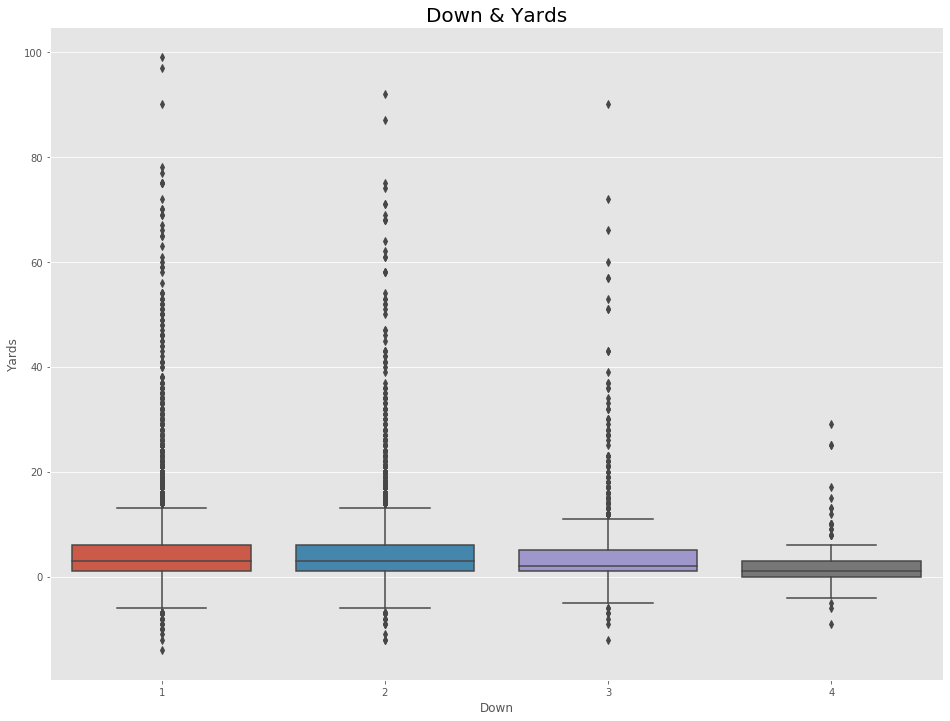

In [49]:
plt.figure(figsize=(16,12))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="Down", y="Yards", showfliers=True)
plt.xlabel('Down', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Down & Yards", fontsize=20)
plt.show()

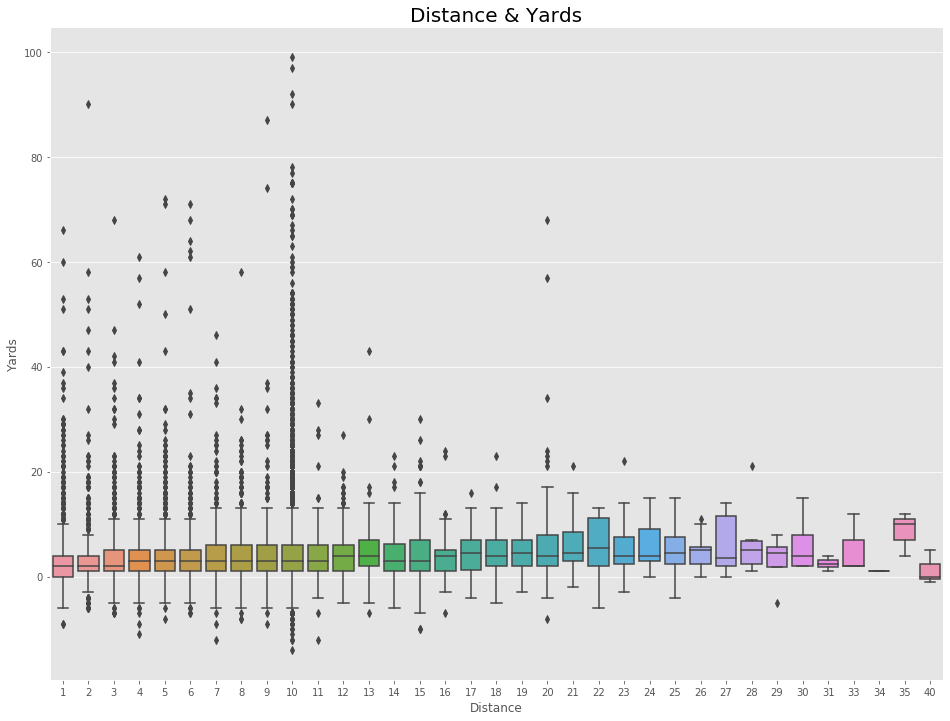

In [50]:
plt.figure(figsize=(16,12))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="Distance", y="Yards", showfliers=True)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Distance & Yards", fontsize=20)
plt.show()

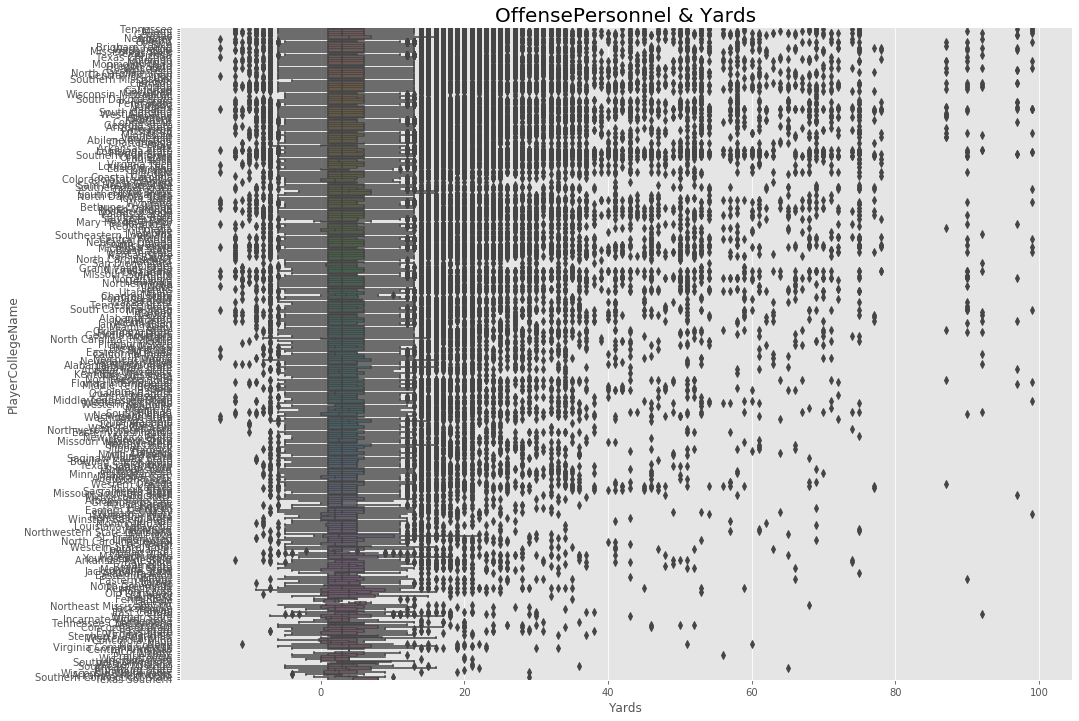

In [51]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="PlayerCollegeName", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PlayerCollegeName', fontsize=12)
plt.title("OffensePersonnel & Yards", fontsize=20)
plt.show()

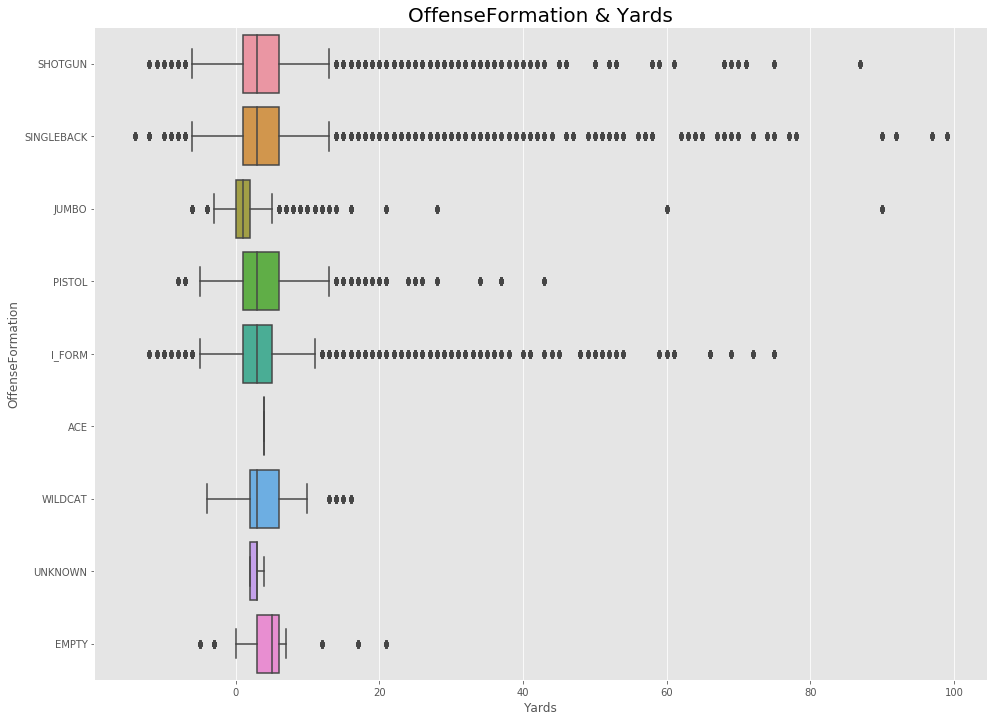

In [52]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="OffenseFormation", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('OffenseFormation', fontsize=12)
plt.title("OffenseFormation & Yards", fontsize=20)
plt.show()

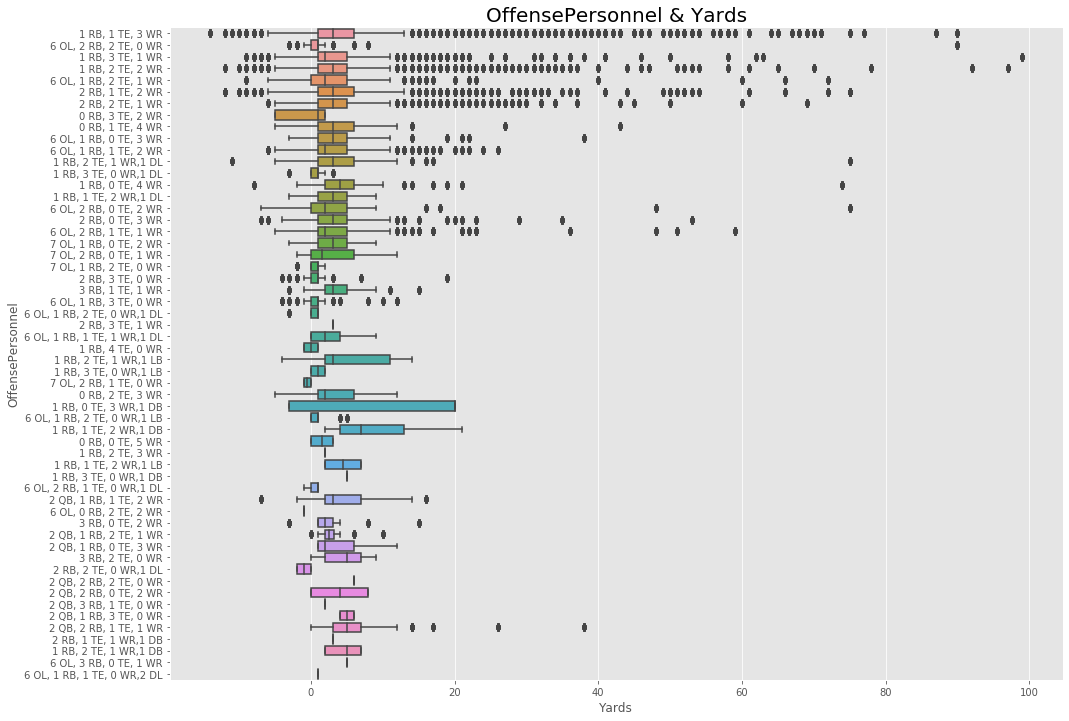

In [53]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="OffensePersonnel", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('OffensePersonnel', fontsize=12)
plt.title("OffensePersonnel & Yards", fontsize=20)
plt.show()

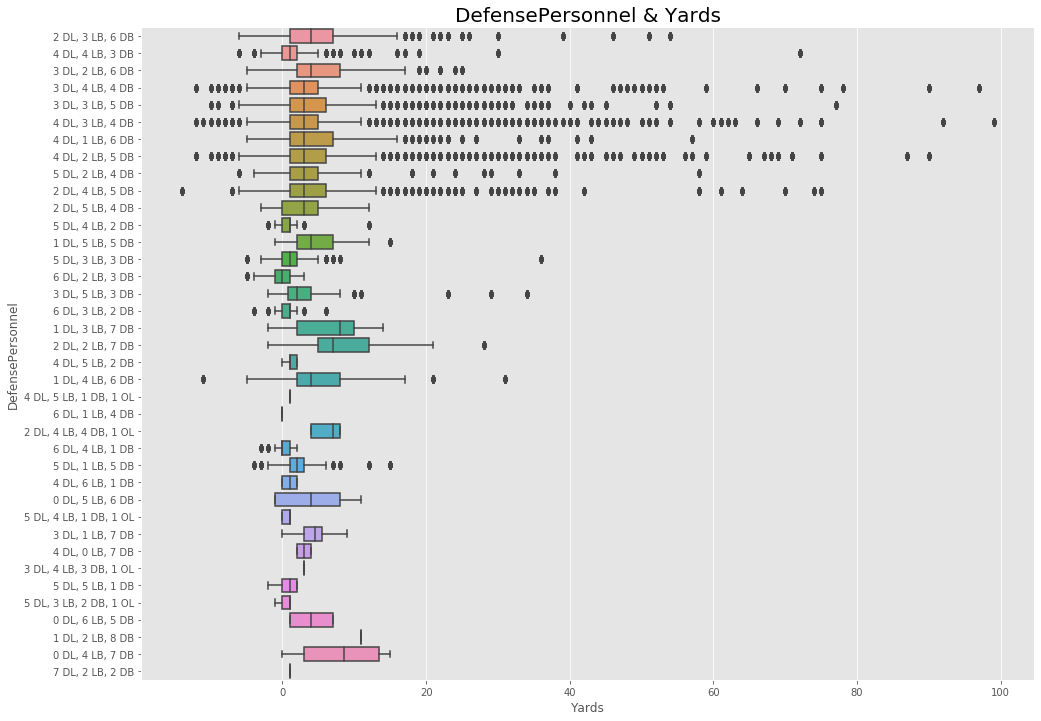

In [54]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="DefensePersonnel", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('DefensePersonnel', fontsize=12)
plt.title("DefensePersonnel & Yards", fontsize=20)
plt.show()

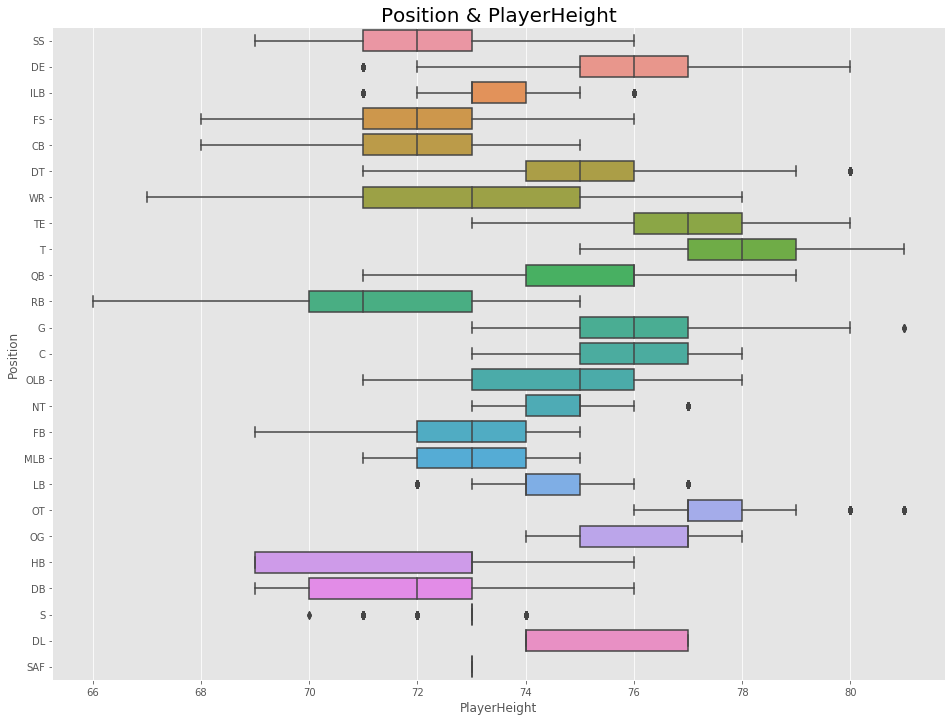

In [55]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="PlayerHeight", y="Position", showfliers=True)
plt.xlabel('PlayerHeight', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title("Position & PlayerHeight", fontsize=20)
plt.show()

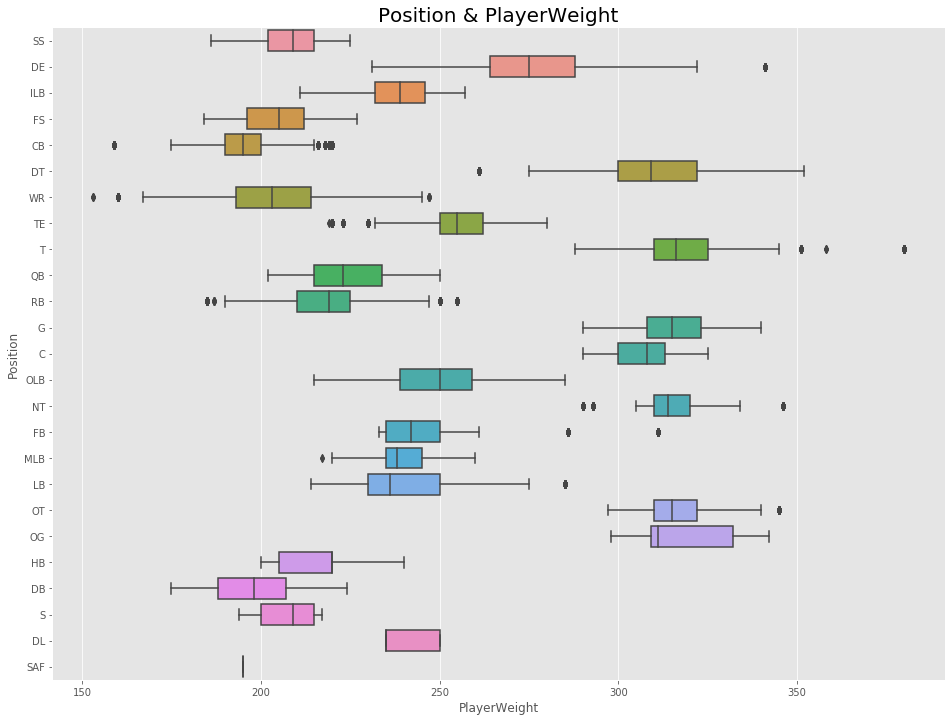

In [56]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="PlayerWeight", y="Position", showfliers=True)
plt.xlabel('PlayerWeight', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title("Position & PlayerWeight", fontsize=20)
plt.show()

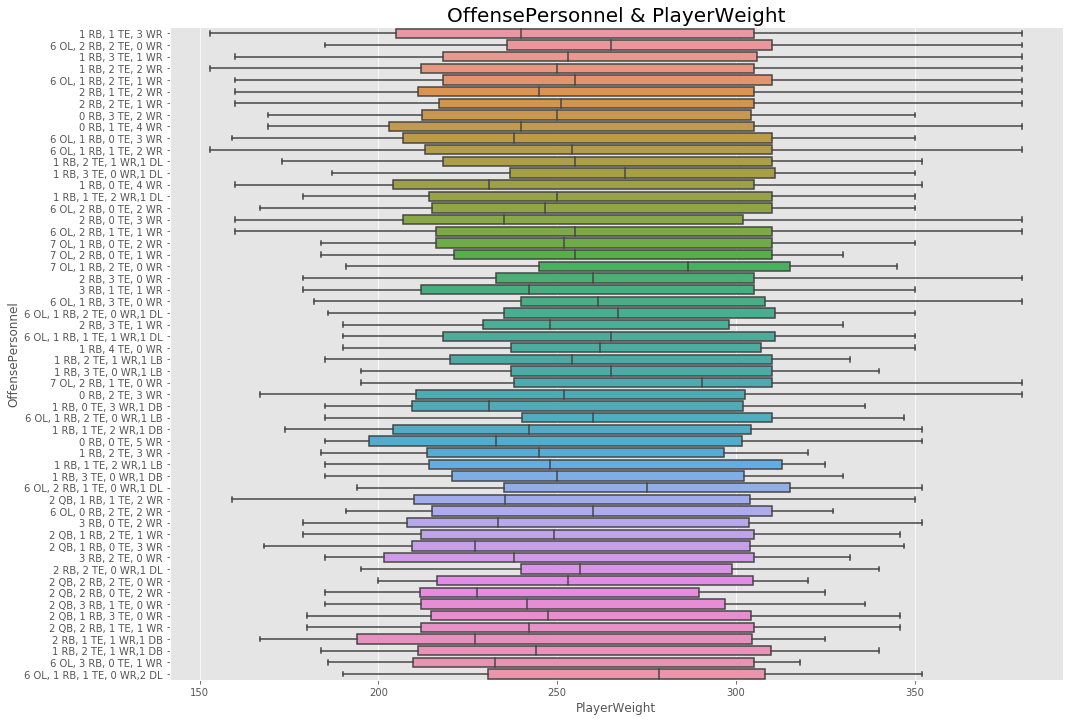

In [57]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="PlayerWeight", y="OffensePersonnel", showfliers=True)
plt.xlabel('PlayerWeight', fontsize=12)
plt.ylabel('OffensePersonnel', fontsize=12)
plt.title("OffensePersonnel & PlayerWeight", fontsize=20)
plt.show()

In [58]:
plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="PlayerHeight", y="OffensePersonnel", showfliers=True)
plt.xlabel('PlayerWeight', fontsize=12)
plt.ylabel('OffensePersonnel', fontsize=12)
plt.title("OffensePersonnel & PlayerHeight", fontsize=20)
plt.show()plt.figure(figsize=(16,12))
sns.boxplot(data=train_df, x="Yards", y="PossessionTeam", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PossessionTeam', fontsize=12)
plt.title("PossessionTeam & Yards", fontsize=20)
plt.show()

SyntaxError: invalid syntax (<ipython-input-58-f60419a18713>, line 6)